In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
folders = ['TM_Chassis_MULT', 'TM_Chassis_Single', 'TM-A_Chassis_MULT', 'TM-A_Chassis_Single']
PCB_num = 0

folder = folders[PCB_num]

dataset_dir = f"/Users/mh/Downloads/datasets/{folder}"

In [12]:
parts = os.listdir(dataset_dir)

i = 0
for part in parts:
    print(i, end=" ")
    print(part)
    i += 1

0 screw2
1 connector1
2 supporter1
3 multiscrew2
4 .DS_Store
5 connector2
6 screw1
7 supporter3
8 supporter2
9 multiscrew1


In [13]:
part_num = 5
part = parts[part_num]

data_dir = f"{dataset_dir}/{part}"
print(data_dir)

/Users/mh/Downloads/datasets/TM_Chassis_MULT/connector2


In [14]:
img_height, img_width = (224, 224)
batch_size = 32

train_data_dir = f"{data_dir}/train"
test_data_dir = f"{data_dir}/test"
valid_data_dir = f"{data_dir}/valid"

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as test data

Found 360 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [16]:
x, y = test_generator.next()
x.shape

(9, 224, 224, 3)

In [17]:
train_generator.num_classes

2

In [18]:
print(f"<{part}>")

base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

if not os.path.exists(f"/Users/mh/Downloads/models/{folder}"):
  os.makedirs(f"/Users/mh/Downloads/models/{folder}")
model.save(f'/Users/mh/Downloads/models/{folder}/{part}.h5')

print()
print(f"{part} saved..\n\n")

<connector2>
Epoch 1/10
12/12 [==============================] - 10s 778ms/step - loss: 0.5787 - accuracy: 0.8611 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
12/12 [==============================] - 9s 730ms/step - loss: 9.9341e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 9s 770ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 10s 798ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 9s 758ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 9s 752ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 9s 779ms/step - loss: 0.0000e+00 - ac

In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy: ', test_acc)

1/1 - 0s - loss: 1.3245e-08 - accuracy: 1.0000 - 286ms/epoch - 286ms/step

Test accuracy:  1.0


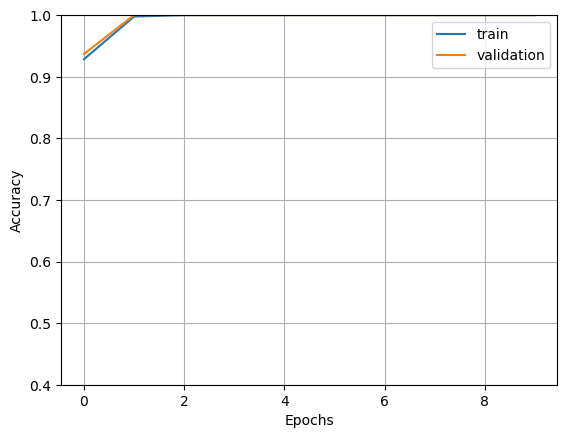

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

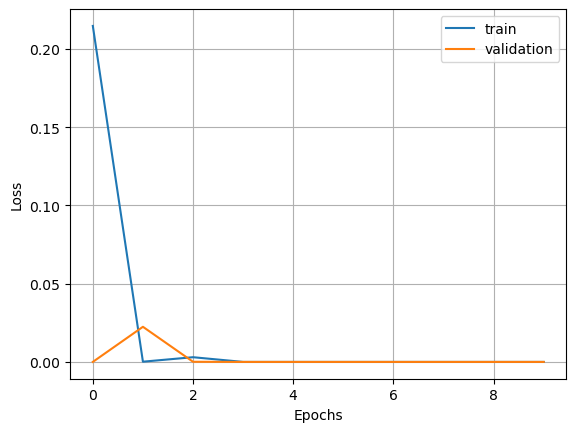

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 0s 355ms/step


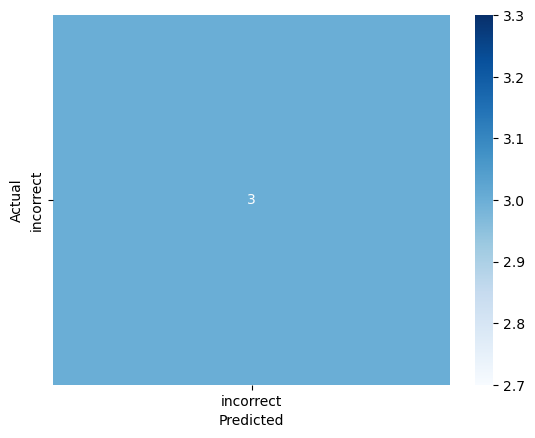

test accuracy: 100.0


In [28]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model(f'/Users/mh/Downloads/models/{folder}/{part}.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test, Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [29]:
import tensorflow as tf
model = tf.keras.models.load_model(f'/Users/mh/Downloads/models/{folder}/{part}.h5')

In [32]:
import cv2
image = cv2.imread('/Users/mh/Downloads/color_case/TM_Chassis_MULT/connector1/case1/case1/TM_Chassis_MULT_6_X_connector1.jpg')
image_resized = cv2.resize(image, (img_height, img_width))
image = np.expand_dims(image_resized, axis=0)
print(image.shape)

(1, 224, 224, 3)


In [33]:
from PIL import Image

pred = model.predict(image)

#cv2.show(np.array(Image.fromarray(image).rezise(img_height, img_width)))
#Image.fromarray(image).show()
print(pred)
if np.argmax(pred[0] + 1) == 0:
    print('correct', np.max(pred[0]))
else: 
    print('incorrect', np.max(pred[0]))

1/1 [==============================] - 0s 59ms/step
[[9.999112e-01 8.879545e-05]]
correct 0.9999112


In [41]:
img_height, img_width = (224, 224)
batch_size = 32

print(f"<<{folder}>>")

for part in parts:
    if part == '.DS_Store':
        continue

    data_dir = f"{dataset_dir}/{part}"

    train_data_dir = f"{data_dir}/train"
    test_data_dir = f"{data_dir}/test"
    valid_data_dir = f"{data_dir}/valid"
    
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.4)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='training') # set as training data

    valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation') # set as validation data

    test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation') # set as test data
    
    x, y = test_generator.next()
    x.shape
    
    train_generator.num_classes
    
    print(f"<{part}>")

    base_model = ResNet50(include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
      layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

    if not os.path.exists(f"/Users/mh/Downloads/models/{folder}"):
      os.makedirs(f"/Users/mh/Downloads/models/{folder}")
    model.save(f'/Users/mh/Downloads/models/{folder}/{part}.h5')

    print()
    print(f"{part} saved..\n\n")

<<TM_Chassis_Single>>
screw2
Found 240 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
<screw2>
Epoch 1/10
8/8 [==============================] - 7s 800ms/step - loss: 0.9870 - accuracy: 0.8500 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 6s 757ms/step - loss: 0.0104 - accuracy: 0.9958 - val_loss: 2.1539e-06 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 6s 740ms/step - loss: 1.4727e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 6s 739ms/step - loss: 2.2848e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 6s 740ms/step - loss: 9.9341e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 6s 739ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 


supporter2 saved..


connector
Found 240 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 5 images belonging to 2 classes.
<connector>
Epoch 1/10
8/8 [==============================] - 7s 879ms/step - loss: 3.9316 - accuracy: 0.6167 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 6s 772ms/step - loss: 0.1923 - accuracy: 0.9458 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 6s 816ms/step - loss: 3.2981e-04 - accuracy: 1.0000 - val_loss: 8.9948e-07 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 6s 773ms/step - loss: 6.9464e-06 - accuracy: 1.0000 - val_loss: 6.8593e-06 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 6s 773ms/step - loss: 3.1675e-04 - accuracy: 1.0000 - val_loss: 2.5323e-05 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 6s 774ms/step - loss: 2.1828e-04 - accuracy: 1.0000 - val_loss